In [ ]:
 %matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
import mne
import numpy as np
import pandas as pd
import mne_connectivity as mn_conn
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne_icalabel import label_components
from pyprep.prep_pipeline import PrepPipeline


In [ ]:
##load data for patient
patient_number = 4
file = rf"neonatal_data\eeg{patient_number}.edf"
data_full = mne.io.read_raw_edf(file,preload = True,verbose=False)
channels_original = data_full.ch_names
## copy the data to apply filtering without including the ekg and respiratory channels
data_eeg = data_full.copy()
montage = mne.channels.read_custom_montage(r"A:\Program Files\MATLAB\R2020a\eeglab2022.1\my_locs\neonatal_channel_loc_mne.loc")
new_channels = {}
montage_channels = montage.ch_names
for n in range (0,len(channels_original)-2):
    new_channels[channels_original[n]] = montage_channels[n]
## add electrode positions
data_eeg.rename_channels(new_channels)
data_eeg.set_montage(montage,on_missing = 'ignore')
## remove respiraotry and ekg channels
if patient_number == 1:
    data_eeg.drop_channels(['ECG EKG-REF','Resp Effort-REF'])
else:
    data_eeg.drop_channels(['ECG EKG','Resp Effort'])

In [ ]:
def run_preprocessing(raw,n_ica_components):
    raw_copy = raw.copy()
    raw_copy.load_data()
    raw_copy.filter(l_freq=1., h_freq=45.,h_trans_bandwidth=1)#.set_eeg_reference()
    ica = ICA(n_components=n_ica_components, max_iter='auto', random_state=97, method='infomax', fit_params=dict(extended=True))
    ica.fit(raw_copy)
    ic_labels = label_components(raw_copy , ica, method="iclabel")
    return ica, ic_labels, raw_copy

In [64]:
ica, ic_labels, raw = run_preprocessing(data_eeg,18)

Fitting ICA took 173.2s.


C:\Users\Szymon Mazurek\AppData\Local\Temp\ipykernel_22328\1851400063.py:7: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_copy , ica, method="iclabel")
C:\Users\Szymon Mazurek\AppData\Local\Temp\ipykernel_22328\1851400063.py:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_copy , ica, method="iclabel")


In [ ]:
data_eeg.plot()

In [65]:
raw_copy = raw.copy()

In [ ]:
raw.plot()

In [66]:
labs = np.array(ic_labels['labels'])
ica.exclude = np.where( (labs!= 'brain'))[0].tolist()

In [67]:
ica.exclude

[0, 1, 4, 5, 6, 7, 8, 10, 11, 13]

Creating RawArray with float64 data, n_channels=18, n_times=876800
    Range : 0 ... 876799 =      0.000 ...  3424.996 secs
Ready.


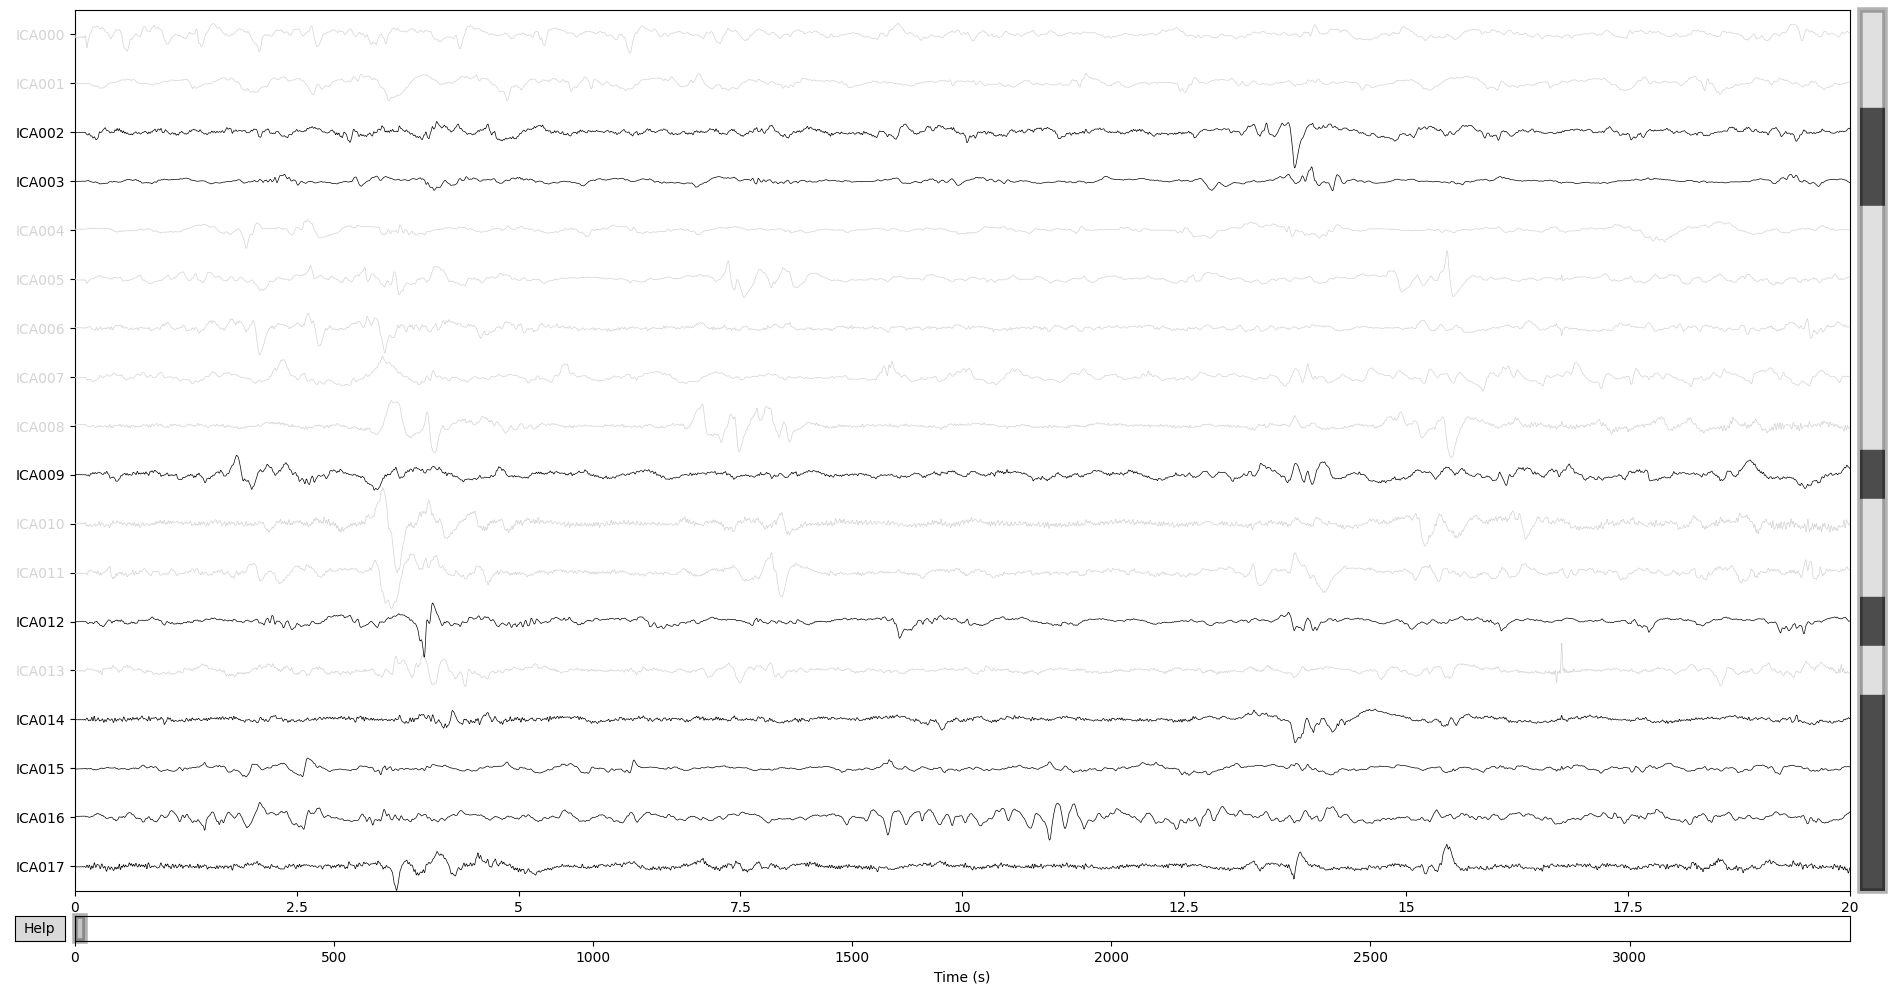

In [68]:
ica.plot_components()
ica.plot_sources(raw_copy)

In [ ]:
ica.exclude = [8,10,1,6,13,17]

In [69]:
ica.apply(raw_copy)

Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 10 ICA components
    Projecting back using 18 PCA components


<RawEDF | eeg4.edf, 19 x 876800 (3425.0 s), ~127.1 MB, data loaded>

In [72]:
raw_copy.set_eeg_reference()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | eeg4.edf, 19 x 876800 (3425.0 s), ~127.1 MB, data loaded>

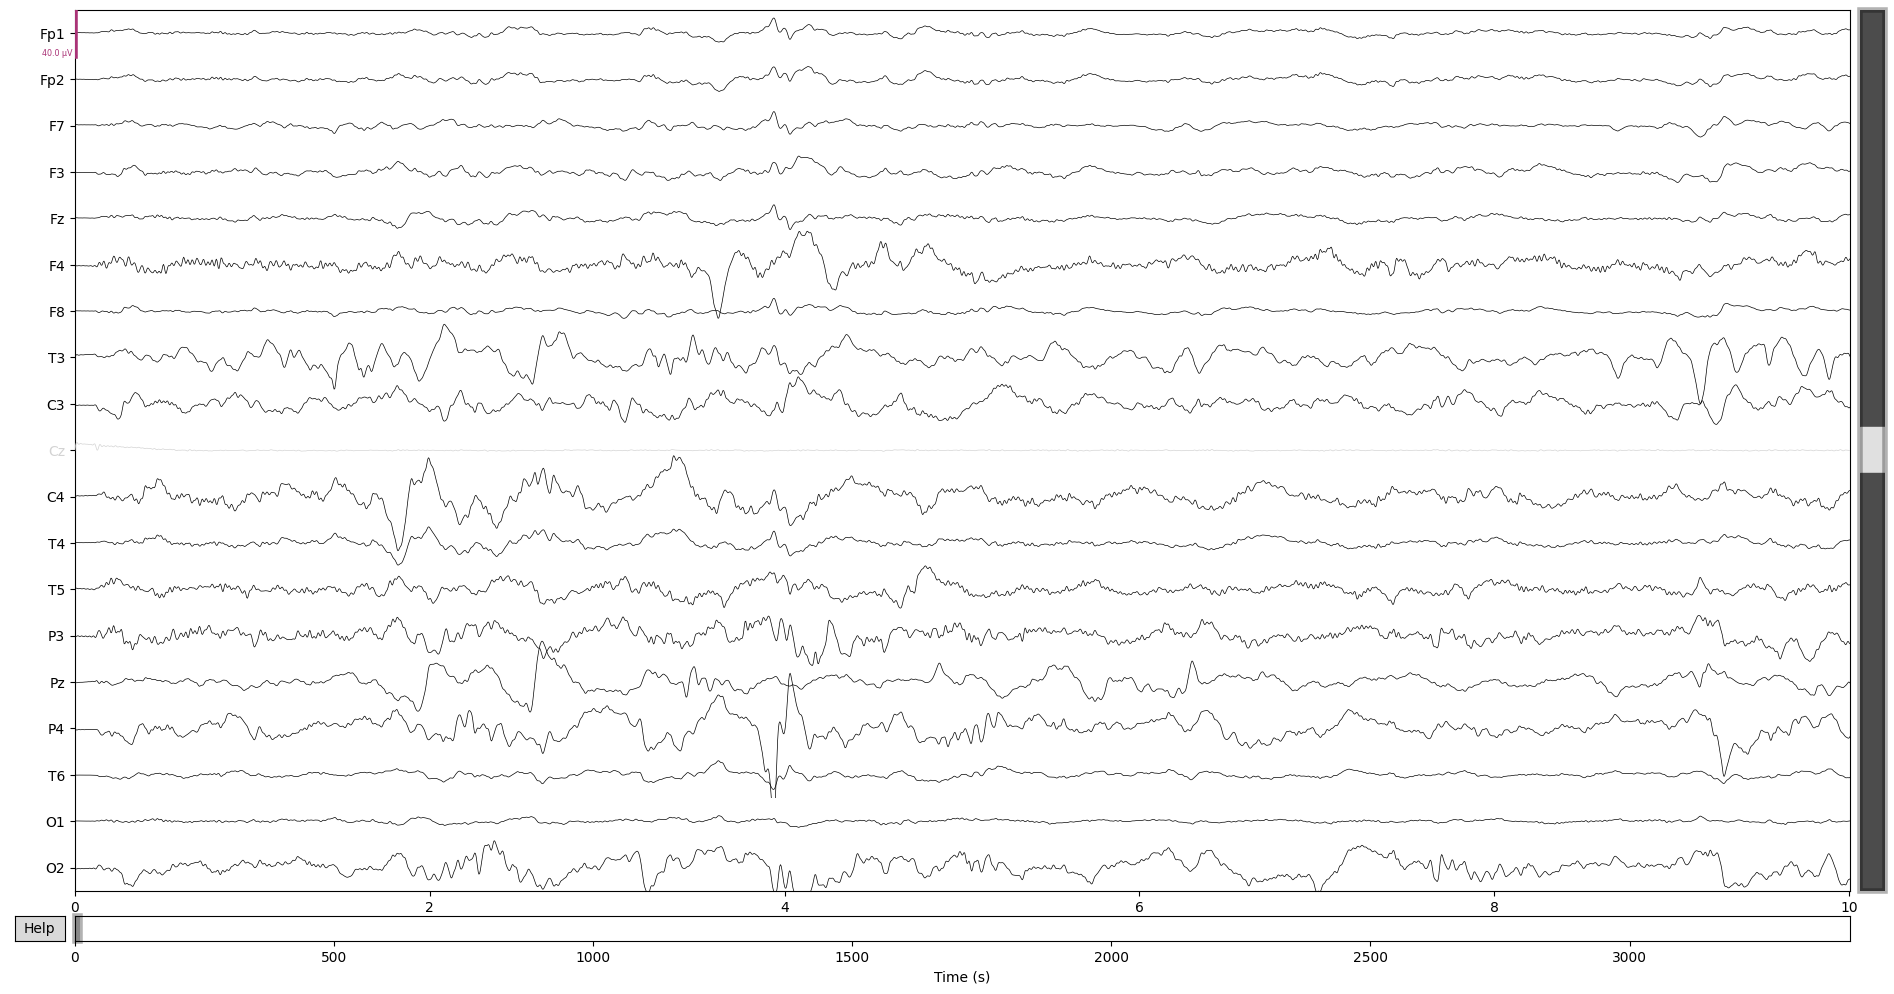

Channels marked as bad:
['Cz']


In [73]:
raw_copy.plot()

In [ ]:
ica.plot_components()

In [ ]:
ica.plot_sources(raw_copy)

In [ ]:
%matplotlib qt

In [ ]:
raw_copy.plot()

In [ ]:
data_eeg.plot()

In [ ]:
prep_params = {
    "ref_chs": "eeg",
    "reref_chs": "eeg",
    "line_freqs": np.arange(50, 256 / 2, 50),
}
montage = data_eeg.get_montage()
prep = PrepPipeline(data_eeg, prep_params,montage,ransac = True,channel_wise =True)
prep_output = prep.fit()

In [ ]:
prep.raw_eeg.plot()

In [ ]:
ch_edited = montage.ch_names

In [ ]:
ch_edited.remove('Cz')

In [ ]:
ch_edited

In [ ]:
"""Annotations of the artifacts done on raw file - no filtering or prior cleaning
just EKG and Resp channels temporairly removed.
"""
events = mne.read_events(rf"A:\Sano\seizure_events\events_per_patient\patient_{patient_number}-eve.fif")
event_dict = {'non_seizure': 0, 'seizure': 1}
# data_eeg.info["bads"] = ["O1"]

# patient_annotations = mne.read_annotations(r"A:\Sano\annotations_1st_patient.csv")
# data_eeg.set_annotations(patient_annotations)
%matplotlib qt
data_eeg.plot(events=events,event_id=event_dict)

In [ ]:
filtered_signal = data_eeg.copy()

In [ ]:
%matplotlib inline

In [ ]:
filtered_signal.filter(l_freq=1., h_freq=45.,h_trans_bandwidth=1).notch_filter(freqs=50)#.set_eeg_reference()

In [ ]:
filtered_signal.plot(events=events,event_id=event_dict)

In [ ]:
filtered_signal.plot_psd(fmax=128)

In [ ]:
%matplotlib qt
filtered_signal.plot(events=events,event_id=event_dict)

In [ ]:
avg_ref_signal = filtered_signal.copy()

In [ ]:
avg_ref_signal.set_eeg_reference()

In [ ]:
avg_ref_signal.plot(events=events,event_id=event_dict)

In [ ]:
signal_for_ica = avg_ref_signal.copy()

In [ ]:
ica = ICA(n_components=18, max_iter='auto', random_state=97, method='infomax',fit_params=dict(extended=True))
ica.fit(filtered_signal)

In [ ]:
ica.plot_components()
ica.plot_sources(filtered_signal)

In [ ]:
# Create epochs for the visual condition
tmin, tmax = 0,1  # need a long enough epoch for 5 cycles
epochs = mne.Epochs(signal_for_ica, events, event_dict, tmin, tmax,
                    baseline=None,preload=True)

In [ ]:
epochs.plot(event_id = event_dict)

In [ ]:
ica_epochs = ICA(n_components=18, method='fastica', max_iter="auto")
ica_epochs.fit(epochs)

In [ ]:
signal_for_ica

In [ ]:
ica_epochs.plot_components()
ica_epochs.plot_sources(signal_for_ica)

In [ ]:
ica_epochs.plot_properties(epochs)

In [ ]:


# Compute connectivity for band containing the evoked response.
# We exclude the baseline period:
fmin, fmax = 4., 9.
sfreq = signal_for_ica.info['sfreq']  # the sampling frequency
tmin = 0.0  # exclude the baseline period
epochs.load_data()  # just keep MEG and no EOG now
con = mn_conn.spectral_connectivity_epochs(
    epochs, method='pli', mode='multitaper', sfreq=sfreq, fmin=fmin, fmax=fmax,
    faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

# Now, visualize the connectivity in 3D:
mn_conn.plot_sensors_connectivity(
    epochs.info,
    con.get_data(output='dense')[:, :, 0])

In [ ]:
 %matplotlib qt

In [ ]:
test_annotated_filtered_full.load_data()
ic_labels = label_components(test_annotated_filtered_full, ica, method='iclabel')

In [ ]:
labels = ic_labels["labels"]
exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]
print(f"Excluding these ICA components: {exclude_idx}")

In [ ]:
eeg_filtered_reconstruct_ica = filtered_signal.copy()
ica.apply(eeg_filtered_reconstruct_ica, exclude=[0, 1, 8 , 10 ,6, 17, 12])

In [ ]:
eeg_filtered_reconstruct_ica.plot(events=events,event_id=event_dict)

In [ ]:
preprocessed_signal = eeg_filtered_reconstruct_ica.set_eeg_reference()

In [ ]:
eeg_filtered_reconstruct_ica.plot()

In [ ]:
"electrical source imaging"
"roadmap of the project, bibliography(applications in epilepsy)"